In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'

In [41]:
import albumentations as A
from albumentations.core.bbox_utils import normalize_bboxes

import json
import shutil
from tqdm.notebook import tqdm
import yaml
import numpy as np
import glob, gc
import cv2

import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import pycocotools.mask as mask_util
from pycocotools import _mask as coco_mask

import ultralytics
from ultralytics import YOLO, SAM
from ultralytics.yolo.utils.ops import scale_boxes, scale_coords, scale_image, non_max_suppression
from ultralytics.nn.tasks import attempt_load_weights
from ultralytics.yolo.v8.segment import SegmentationPredictor
from ultralytics.yolo.utils import IterableSimpleNamespace, DEFAULT_CFG_KEYS, DEFAULT_CFG_DICT, DEFAULT_CFG
from copy import deepcopy
ultralytics.checks()


Ultralytics YOLOv8.0.120 🚀 Python-3.9.17 torch-1.10.2+cu113 CUDA:0 (NVIDIA A100 80GB PCIe, 81251MiB)
Setup complete ✅ (64 CPUs, 376.5 GB RAM, 721.5/915.6 GB disk)


In [3]:
def imshow(mask):
    fig = plt.figure()
    if len(mask.shape) == 3:
        plt.imshow(np.any(mask.astype(bool), 0))
    else:
        plt.imshow(mask)
    plt.plot()

In [4]:
from skimage.morphology import binary_dilation, binary_closing, binary_opening
from skimage.measure import label, regionprops

def join_masks(masks: np.ndarray):
    """masks in shape n x W x H """
    return np.any(masks, axis=0).astype(int)

def substact_masks(mask1, mask2):
    substraction = mask1 & ~mask2
    if len(substraction) == 0:
        return np.zeros_like(mask1)
    return substraction

def disjoin_mask(mask):
    """mask in shape W x H"""
    if not np.any(mask):
        return mask[None, :, :]
    labeled_mask = label(mask)  # Результат - маска, где каждый объект имеет уникальное число
    props = regionprops(labeled_mask)

    new_masks = []
    for prop in props:
        new_mask = np.zeros_like(mask)
        new_mask[labeled_mask == prop.label] = 1
        new_masks.append(new_mask)

    new_masks_array = np.array(new_masks)
    return new_masks_array

def dilate_mask(mask, n_iter=1):
    for _ in range(n_iter):
        mask = binary_dilation(mask)
    return mask

def dilate_predict_mask(masks, n_iter=1):
    for i in range(len(masks)):
        for _ in range(n_iter):
            masks[i] = binary_dilation(masks[i])
    return masks

In [5]:
def set_seed(seed=42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [6]:
# !pip install --no-index \
# /kaggle/input/wbf-download-code-for-offline-installation/Weighted-Boxes-Fusion/ensemble_boxes-1.0.7-py3-none-any.whl \
# --find-links=/kaggle/input/wbf-download-code-for-offline-installation/Weighted-Boxes-Fusion

In [7]:
# !pip install ensemble-boxes

In [8]:
from skimage import draw

def make_negative_mask(annotations, size=(512, 512)):
    mask = np.zeros(size, dtype=np.float32)
    for annot in annotations:
        cords = annot['coordinates']
        if annot['type'] == "glomerulus":
            for cord in cords:
                rr, cc = np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord])
                rr, cc = draw.polygon(rr, cc)
                mask[rr, cc] = 1
    return mask

def make_masks(annotations, size=(512, 512)):
    masks = []
    for annot in annotations:
        mask = np.zeros(size, dtype=np.float32)
        cords = annot['coordinates']
        if annot['type'] == "blood_vessel":
            for cord in cords:
                rr, cc = np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord])
                rr, cc = draw.polygon(rr, cc)
                mask[rr, cc] = 1
            masks.append(mask)
    if len(masks) == 0:
        masks.append(np.zeros(size, dtype=np.float32))
    return np.stack(masks)

In [9]:
def parse_ann(annotations):
    target = []
    for annot in annotations:
        if annot['type'] == "blood_vessel":
            target.append(np.array(annot['coordinates']).flatten().tolist())
    return target

In [10]:
from metrics import MAPCalculatorSingleClass

# Training

In [11]:
with open('../data/polygons.jsonl', 'r') as json_file:
    json_labels = [json.loads(line) for line in json_file]

id_to_annotation = {j['id']: j['annotations'] for j in json_labels}

In [12]:
DATA_BASE = 'dataset'
BASE_FILENAME = '../data/'

In [13]:
def evaluate_model(annotations, prediction_masks, predicition_scores):
    mAP_calc = MAPCalculatorSingleClass()
    height, width = (512, 512)
    ious = [] 
    for ann, pred_masks, scores in zip(annotations, prediction_masks, predicition_scores):
        if len(ann) == 0:
            continue
        enc_gt = coco_mask.frPyObjects(ann, height, width)
        num_gts = len(enc_gt)
        enc_pred = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
        
        _ious = mask_util.iou(enc_pred, enc_gt, [0]*len(enc_gt))
        mAP_calc.accumulate(_ious, scores, num_gts)
        score = mAP_calc.evaluate()[0]
        ious.append(score)
    return ious

In [15]:
model = YOLO('HuBMAP/one_class_yolov8x-seg-fold0/weights/best.pt')

In [20]:
ious = []
for i in [0, 1, 2, 3, 4]:
    model = YOLO(f'HuBMAP/one_class_yolov8x-seg-fold{i}/weights/best.pt')
    metrics = model.val(iou=0.6, conf=0.01, retina_masks=True, verbose=False)
    iou = metrics.seg.all_ap[0][2]
    print(iou)
    ious.append(iou)

Ultralytics YOLOv8.0.120 🚀 Python-3.9.17 torch-1.10.2+cu113 CUDA:0 (NVIDIA A100 80GB PCIe, 81251MiB)
YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients
val: Scanning /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold0/valid.cache... 327 images, 2 backgrounds, 0 corrupt: 100%|██████████| 327/327 [00:00<?, ?it/s]
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold0/valid/01a7fca6263b.tif: 7 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold0/valid/0bc3e1a729e4.tif: 7 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold0/valid/0f6e1cb07f74.tif: 7 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold0/valid/270f0c7b0901.tif: 9 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold0/

0.7015764813252315


Ultralytics YOLOv8.0.120 🚀 Python-3.9.17 torch-1.10.2+cu113 CUDA:0 (NVIDIA A100 80GB PCIe, 81251MiB)
YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients
val: Scanning /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold1/valid.cache... 327 images, 4 backgrounds, 0 corrupt: 100%|██████████| 327/327 [00:00<?, ?it/s]
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold1/valid/0672b96aaccc.tif: 4 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold1/valid/15262223b967.tif: 11 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold1/valid/1c0295c1d01d.tif: 3 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold1/valid/228da07bf8d9.tif: 6 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold1

0.6511539680863534


Ultralytics YOLOv8.0.120 🚀 Python-3.9.17 torch-1.10.2+cu113 CUDA:0 (NVIDIA A100 80GB PCIe, 81251MiB)
YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients
val: Scanning /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold2/valid.cache... 327 images, 1 backgrounds, 0 corrupt: 100%|██████████| 327/327 [00:00<?, ?it/s]
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold2/valid/1fc1c6cc515a.tif: 11 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold2/valid/314a25a7f92d.tif: 7 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold2/valid/328a651a4ca7.tif: 12 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold2/valid/36be7dacbabf.tif: 11 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fol

0.5951571674990264


Ultralytics YOLOv8.0.120 🚀 Python-3.9.17 torch-1.10.2+cu113 CUDA:0 (NVIDIA A100 80GB PCIe, 81251MiB)
YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients
val: Scanning /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold3/valid.cache... 326 images, 2 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold3/valid/025ec20b8b73.tif: 7 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold3/valid/033a656390b2.tif: 3 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold3/valid/3398c337fe7a.tif: 8 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold3/valid/6d1315ab9ef7.tif: 7 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold3/

0.6593284832585142


Ultralytics YOLOv8.0.120 🚀 Python-3.9.17 torch-1.10.2+cu113 CUDA:0 (NVIDIA A100 80GB PCIe, 81251MiB)
YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients
val: Scanning /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold4/valid.cache... 326 images, 2 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold4/valid/07b809228ef4.tif: 4 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold4/valid/0a993633aa5e.tif: 7 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold4/valid/0ba172f33ea6.tif: 6 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold4/valid/0ce440ad7080.tif: 12 duplicate labels removed
val: WARNING ⚠️ /home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/folds_new/fold4

0.6850627013976138


In [22]:
np.mean(ious)

0.658455760313348

In [23]:
def predict(
    image,
    models,
    transforms=[None],
    imgsz=512,
    conf=0.01,
    iou_nms=0.5,
    retina_masks=True,
):
    boxes, masks, scores = [], [], []

    og_img = np.array(image.copy()).astype(np.uint8)[..., ::-1] # bgr to rgb
    h, w = og_img.shape[:2]

    for model in models:
        for transform in transforms:
            if transform is not None:
                img = transform(image=og_img)["image"]
            else:
                img = og_img.copy()

            pred = model.predict(
                img, imgsz=imgsz, conf=conf, iou=iou_nms, retina_masks=retina_masks, verbose=False, 
            )[0]

            if pred.masks is None:
                continue

            pred_masks = pred.masks.data[pred.boxes.cls == 0].detach().cpu().numpy()

            if len(pred_masks) == 0:
                continue
            pred_confs = pred.boxes.conf[pred.boxes.cls == 0].detach().cpu().numpy()
            pred_boxes = pred.boxes.xyxyn[pred.boxes.cls == 0].detach().cpu().numpy()

            if transform is not None:
                out = transform(image=img, bboxes=pred_boxes, masks=pred_masks)
                pred_boxes = out["bboxes"]
                pred_masks  = out["masks"]

            boxes.append(np.array(pred_boxes))
            masks.append(pred_masks)
            scores.append(np.array(pred_confs))
            del pred, pred_boxes, pred_masks, img
    del og_img
    if len(boxes) == 0:
        return np.array([]), np.array([]), np.array([])
    
    return np.concatenate(boxes), np.concatenate(masks).astype(np.uint8), np.concatenate(scores)

In [26]:
from ensemble_boxes_nms import nms

def combine_results_nmms(boxes, masks, scores, iou_thr=0.8, weights=None):
    nms_boxes, nms_scores = nms(
                            [boxes],
                            [scores],
                            iou_thr=iou_thr,
                            weights=weights,
                           )

    nms_masks = []
    scores_list = scores.tolist()
    for s in nms_scores:
        nms_masks.append(masks[scores_list.index(s)])
    nms_masks = np.stack(nms_masks).astype(bool)
    nms_scores = np.array(nms_scores)
    
    return nms_masks, nms_scores

In [111]:
from wbf_tracking import weighted_boxes_fusion_tracking as wbf_tracking

def bbox_to_key(bbox):
    return ','.join(map(str, np.round(bbox, 4)))
    

def combine_results_wbf(boxes, masks, scores, iou_thr=0.55, skip_box_thr=0.0, label_thr=0, weights=None):
    bbox_to_idx = {}
    h, w = masks.shape[-2:]
    
    for i, (mask, box) in enumerate(zip(masks, boxes)):
        bbox_to_idx[bbox_to_key(box)] = i
    
    labels = np.ones(len(boxes))  
    wbf_boxes, _, _, wbf_ogs = wbf_tracking(
        [boxes],
        [scores],
        labels_list=[labels],
        iou_thr=iou_thr,
        skip_box_thr=skip_box_thr,
        weights=weights,
    )

    wbf_masks, wbf_scores = [], []
    for i, wbf_box in enumerate(wbf_boxes):
        filter_box = np.zeros((h, w), dtype=np.uint8)
        
        x1 = max(0, int(h * wbf_box[0]))
        y1 = max(0, int(w * wbf_box[1]))
        x2 = min(h, int(h * wbf_box[2]))
        y2 = min(w, int(w * wbf_box[3]))
        filter_box[y1:y2, x1:x2] = 1
        
        keep = []
        for og_box in wbf_ogs[i]:
            key = bbox_to_key(og_box[4:])
            if key in bbox_to_idx:
                keep.append(bbox_to_idx[key])
            else:
                continue
#         if len(keep) == 0:
        if len(keep) < 3:
            wbf_mask = np.zeros((h, w), dtype=np.uint8)
            wbf_score = 0
        else:
            wbf_mask = (np.mean(masks[keep], axis=0) >= label_thr).astype(bool)
#             wbf_mask = wbf_mask & filter_box # remove pixels outside wbf
            wbf_score = np.mean(scores[keep])

        wbf_masks.append(wbf_mask)
        wbf_scores.append(wbf_score)
    
    wbf_masks = np.stack(wbf_masks)
    wbf_scores = np.array(wbf_scores) 
    return wbf_masks, wbf_scores

In [75]:
image_id = '016c33dacfa1'
model = YOLO('/home/worker/workspace/hacks/HuBMAP_vasculative/pybooks/HuBMAP/one_class_yolov8x-seg-fold0/weights/best.pt')
image = Image.open(f'../data/train/{image_id}.tif')

In [77]:
raw_boxes, raw_masks, raw_scores = predict(image, [model], iou_nms=0.9, transforms = [None, A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Rotate(limit=(180,180), p=1.0)]
)
gt_mask = make_masks(id_to_annotation[image_id])

In [76]:
pred =model(image)[0]


0: 512x512 12 blood_vessels, 23.5ms
Speed: 2.4ms preprocess, 23.5ms inference, 9.1ms postprocess per image at shape (1, 3, 512, 512)


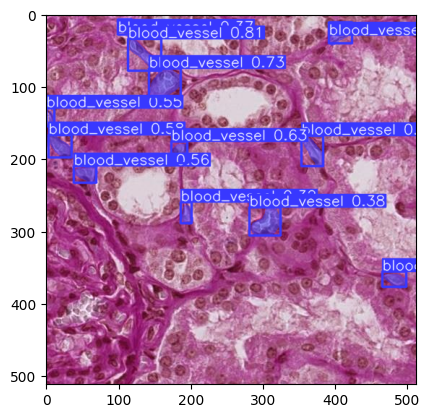

In [78]:
plt.imshow(pred.plot())

In [79]:
wbf_masks, wbf_scores = combine_results_wbf(raw_boxes, raw_masks, raw_scores, label_thr=0.9)
nms_masks, nms_scores = combine_results_nmms(raw_boxes, raw_masks, raw_scores)

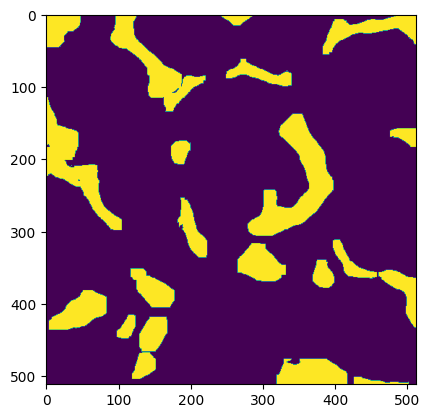

In [80]:
imshow(raw_masks)

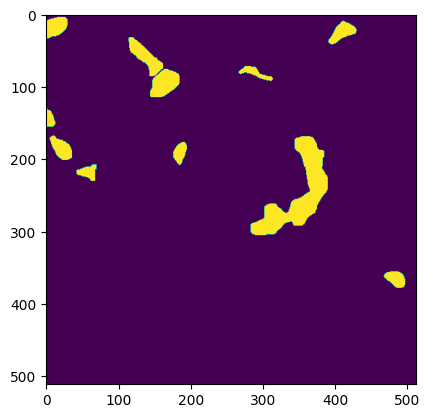

In [81]:
imshow(gt_mask)

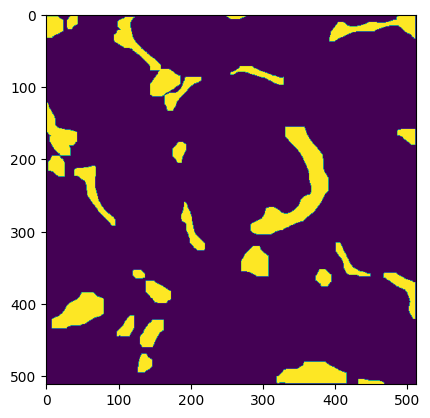

In [82]:
imshow(wbf_masks)

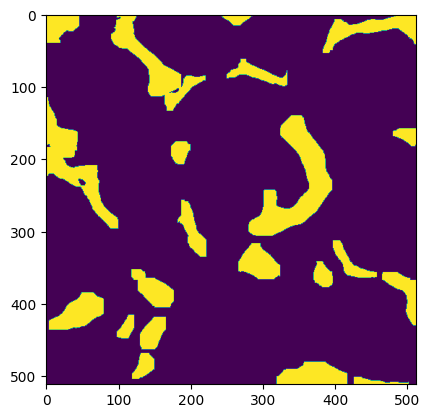

In [50]:
imshow(nms_masks)

In [54]:
transforms = [None, A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Rotate(limit=(180,180), p=1.0)]

In [113]:
from dataclasses import dataclass

@dataclass
class CFG:
    dilation_n_iter: int = 1
    conf: float = 0.01
    imgsz: int = (512, 512)
    retina_masks: bool = True
    iou_nms: float = 0.6
    iou_nms_tta: float = 0.7
    wbf_label_thr: float = 0.7
    postprocces_type: str = 'wbf' # or wbf or nms
        
#     transforms: tuple = (None, )
    transforms: tuple = (None, A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Rotate(limit=(180,180), p=1.0))
    
    models = [
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold0.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold1.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold2.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold3.pt',
        '/kaggle/input/models-hubmap-vasculative/yolov8x-seg-fold4.pt',
    ]

    def __repr__(self):
        return f"CFG({', '.join(f'{k}={v}' for k, v in self.__dict__.items())})"

In [114]:
FOLDS_ROOT = 'folds_new/'
PROJECT = 'HuBMAP'
MODEL_V = 'yolov8x-seg'
PREFIX = 'one_class_'
folds_i = [0, 1, 2, 3, 4]


folds_iou = dict()
for i in folds_i:
    path_to_data = f'{FOLDS_ROOT}/fold{i}/hubmap-coco.yaml'


    model = YOLO(f'{PROJECT}/{PREFIX}{MODEL_V}-fold{i}/weights/best.pt')


    val_dir = f'{FOLDS_ROOT}/fold{i}/valid/'
    val_ids = [r.split('.')[0] for r in os.listdir(val_dir) if r.endswith('.txt')]

    annotations = []
    pred_masks = []
    pred_scores = []
    for image_id in val_ids[:100]:
        annotations.append(parse_ann(id_to_annotation[image_id]))
        image = Image.open(os.path.join(val_dir ,image_id+'.tif'))

        raw_boxes, raw_masks, raw_scores = predict(image=image,
                                models=[model],
                                transforms=CFG.transforms,
                                imgsz=CFG.imgsz,
                                conf=CFG.conf,
                                iou_nms=CFG.iou_nms,
                                retina_masks=CFG.retina_masks,
                               )
        if len(raw_boxes) == 0:
            masks = np.zeros((1, *image.size), dtype=np.uint8)
            scores = np.array([0])
        elif CFG.postprocces_type == 'nms':
            masks, scores = combine_results_nmms(raw_boxes, raw_masks, raw_scores, iou_thr=CFG.iou_nms_tta)
        elif CFG.postprocces_type == 'wbf':
            masks, scores = combine_results_wbf(raw_boxes, raw_masks, raw_scores, iou_thr=CFG.iou_nms_tta, label_thr=CFG.wbf_label_thr)

        masks = dilate_predict_mask(masks, CFG.dilation_n_iter)
        pred_masks.append(masks)
        pred_scores.append(scores)

    ious = evaluate_model(annotations, pred_masks, pred_scores)
    folds_iou[i] = ious

    print(f'fold {i}')
    print(f'IOU mean: {np.mean(ious):.4}')
    print(f'IOU std: {np.std(ious):.4}')
    print()

print('overall')
print(f'mean {np.mean(sum(folds_iou.values(), [])):.4}')
print(f'std {np.std(sum(folds_iou.values(), [])):.4}')
print(CFG())

fold 0
IOU mean: 0.5644
IOU std: 0.04664



KeyboardInterrupt: 

In [ ]:
# fold 0
# IOU mean: 0.5878
# IOU std: 0.03131

# fold 1
# IOU mean: 0.6266
# IOU std: 0.02326

# fold 2
# IOU mean: 0.5871
# IOU std: 0.02105

# fold 3
# IOU mean: 0.6116
# IOU std: 0.02441

# fold 4
# IOU mean: 0.5425
# IOU std: 0.01961

# overall
# mean 0.5911
# std 0.03745
# CFG(dilation_n_iter=1, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.6, iou_nms_tta=0.7, wbf_label_thr=0.7, postprocces_type=wbf, transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0), Rotate(always_apply=False, p=1.0, limit=(180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False)))

In [90]:
# fold 0
# IOU mean: 0.5271
# IOU std: 0.0332

# fold 1
# IOU mean: 0.5233
# IOU std: 0.02864

# fold 2
# IOU mean: 0.5229
# IOU std: 0.03155

# fold 3
# IOU mean: 0.4992
# IOU std: 0.03389

# fold 4
# IOU mean: 0.5266
# IOU std: 0.03169

# overall
# mean 0.5199
# std 0.03348
# CFG(dilation_n_iter=1, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.6, wbf_label_thr=0.6, postprocces_type=wbf, transforms=(None, HorizontalFlip(always_apply=False, p=1.0), VerticalFlip(always_apply=False, p=1.0)))

In [ ]:
# fold 0
# IOU mean: 0.5974
# IOU std: 0.01184

# fold 1
# IOU mean: 0.5942
# IOU std: 0.02097

# fold 2
# IOU mean: 0.5942
# IOU std: 0.01877

# fold 3
# IOU mean: 0.5703
# IOU std: 0.03646

# fold 4
# IOU mean: 0.5905
# IOU std: 0.02505

# overall
# mean 0.5894
# std 0.02586
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.8)

In [ ]:
# fold 0
# IOU mean: 0.512
# IOU std: 0.0288

# fold 1
# IOU mean: 0.485
# IOU std: 0.0254

# fold 2
# IOU mean: 0.479
# IOU std: 0.0229

In [ ]:
print(CFG())

In [ ]:
for i in folds_i:
    print(f'fold {i}')
    print(f'IOU mean: {np.mean(folds_iou[i]):.3}')
    print(f'IOU std: {np.std(folds_iou[i]):.3}')
print('overall')
print(f'mean {np.mean(sum(folds_iou.values(), [])):.3}')
print(f'std {np.std(sum(folds_iou.values(), [])):.3}')

In [ ]:
# CFG(dilation_n_iter=1, conf=0.05,
# imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.3
# fold 0
# IOU mean: 0.5
# IOU std: 0.0275
# fold 1
# IOU mean: 0.485
# IOU std: 0.0296
# fold 2
# IOU mean: 0.477
# IOU std: 0.0284
# fold 3
# IOU mean: 0.441
# IOU std: 0.0327
# fold 4
# IOU mean: 0.468
# IOU std: 0.0276
# overall
# mean 0.474
# std 0.0352

In [ ]:
print()

In [ ]:
raw_masks.shape

In [ ]:
image_id
image = Image.open(os.path.join(val_dir ,image_id+'.tif'))
gt_mask = make_masks(id_to_annotation[image_id])

In [ ]:
imshow(gt_mask)

In [ ]:
image

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.3, iou_nms_tta=0.3, author=tg @ai_minds, sam_model=sam_l.pt)
# fold 0 IOU mean: 0.5810630028728818
# fold 0 IOU std: 0.01242938740762414
# fold 1 IOU mean: 0.5862236411273175
# fold 1 IOU std: 0.022572651887895537
# fold 2 IOU mean: 0.577123098152969
# fold 2 IOU std: 0.021627394262583248
# fold 3 IOU mean: 0.5526609675078908
# fold 3 IOU std: 0.03596290372500657
# fold 4 IOU mean: 0.5772421264235482
# fold 4 IOU std: 0.02602384296638565

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.3, iou_nms_tta=0.3, author=tg @ai_minds, sam_model=sam_l.pt)
# fold 0 IOU mean: 0.5810630028728818
# fold 0 IOU std: 0.01242938740762414
# fold 1 IOU mean: 0.5862236411273175
# fold 1 IOU std: 0.022572651887895537
# fold 2 IOU mean: 0.577123098152969
# fold 2 IOU std: 0.021627394262583248
# fold 3 IOU mean: 0.5526609675078908
# fold 3 IOU std: 0.03596290372500657
# fold 4 IOU mean: 0.5772421264235482
# fold 4 IOU std: 0.02602384296638565

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.7, author=tg @ai_minds)
# fold 0
# IOU mean: 0.5813883380571195
# IOU std: 0.021602333573493074
# fold 1
# IOU mean: 0.5718512034934188
# IOU std: 0.021204994571685447
# fold 2
# IOU mean: 0.577511672296694
# IOU std: 0.01872297097533825
# fold 3
# IOU mean: 0.5571941140070192
# IOU std: 0.03718892123463371
# fold 4
# IOU mean: 0.5767471303179905
# IOU std: 0.031885737575472674

In [ ]:
i = 0
path_to_data = f'{FOLDS_ROOT}/fold{i}/hubmap-coco.yaml'


model = YOLO(f'{PROJECT}/{MODEL_V}-fold{i}/weights/best.pt')


val_dir = f'{FOLDS_ROOT}/fold{i}/valid/'
val_ids = [r.split('.')[0] for r in os.listdir(val_dir) if r.endswith('.txt')]
annotations = [parse_ann(ANN_DICT[image_id]) for image_id in val_ids]
images = [Image.open(os.path.join(val_dir ,image_id+'.tif')) for image_id in val_ids]

In [ ]:
tile_meta = pd.read_csv("../data/tile_meta.csv")

In [ ]:
tile_meta

In [ ]:
for i in folds_i:
    print(f'fold {i}')
    print(f'IOU mean: {np.mean(folds_iou[i])}')
    print(f'IOU std: {np.std(folds_iou[i])}')


In [ ]:
for i in folds_i:
    print(f'fold {i}')
    print(f'IOU mean: {np.mean(folds_iou[i])}')
    print(f'IOU std: {np.std(folds_iou[i])}')


In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.7, author=tg @ai_minds)
# fold 0
# IOU mean: 0.5813883380571195
# IOU std: 0.021602333573493074
# fold 1
# IOU mean: 0.5718512034934188
# IOU std: 0.021204994571685447
# fold 2
# IOU mean: 0.577511672296694
# IOU std: 0.01872297097533825
# fold 3
# IOU mean: 0.5571941140070192
# IOU std: 0.03718892123463371
# fold 4
# IOU mean: 0.5767471303179905
# IOU std: 0.031885737575472674

In [ ]:
# CFG(dilation_n_iter=0, conf=0.01, imgsz=(512, 512), retina_masks=True, iou_nms=0.7, iou_nms_tta=0.5, author=tg @ai_minds)
# fold 0
# IOU mean: 0.5814528026638007
# IOU std: 0.01993106164995504
# fold 1
# IOU mean: 0.5742532196320681
# IOU std: 0.021325379354314125
# fold 2
# IOU mean: 0.5681236433177105
# IOU std: 0.017857128449938295
# fold 3
# IOU mean: 0.5616550087820426
# IOU std: 0.04004046646567095
# fold 4
# IOU mean: 0.581137718008946
# IOU std: 0.02790984538510792

In [ ]:
# fold 0
# IOU mean: 0.5814528026638007
# IOU std: 0.01993106164995504
# fold 1
# IOU mean: 0.5742532196320681
# IOU std: 0.021325379354314125
# fold 2
# IOU mean: 0.5681236433177105
# IOU std: 0.017857128449938295
# fold 3
# IOU mean: 0.5616550087820426
# IOU std: 0.04004046646567095
# fold 4
# IOU mean: 0.581137718008946
# IOU std: 0.02790984538510792

In [ ]:
# NO TTA:
# fold 0 IOU mean: 0.5226953892026813
# fold 0 IOU std: 0.029872814532010492

In [ ]:
# WITH TTA:
# fold 0 IOU mean: 0.58
# fold 0 IOU std: 0.019

In [ ]:
#     mosaic=True: Аугментация изображений с помощью объединения нескольких изображений в одно (mosaic augmentation).
#     mixup=0.5: Случайное смешивание изображений для создания новых изображений (mixup augmentation).
#     random_placing=True: Случайное размещение объектов на изображении (random object placing augmentation).
#     hsv_augmentation=True: Изменение цветового пространства изображений (HSV augmentation).
#     degrees=10.0: Вращение изображений на случайный угол (rotation augmentation).
#     translate=0.1: Случайное смещение изображений по горизонтали и вертикали (translation augmentation).
#     scale=0.5: Масштабирование изображений на случайный коэффициент (scale augmentation).
#     shear=2.0: Наклон изображений на случайный угол (shear augmentation).
#     perspective=0.0: Изменение перспективы изображений (perspective augmentation).
#     flipud=0.5: Отражение изображений по вертикали (vertical flip augmentation).
#     fliplr=0.5: Отражение изображений по горизонтали (horizontal flip augmentation).
#     mosaic_scale=[0.5, 1.5]: Масштабирование мозаики изображений на случайный коэффициент.

# INFERENCE

In [ ]:
model = YOLO('HuBMAP/yolov8x-seg10/weights/best.pt')

In [ ]:
DATA_BASE = 'dataset'
BASE_FILENAME = '../data/'

In [ ]:
from skimage.morphology import binary_dilation, binary_closing, binary_opening
from skimage.measure import label, regionprops

def join_masks(masks: np.ndarray):
    """masks in shape n x W x H """
    return np.any(masks, axis=0).astype(int)

def substact_masks(mask1, mask2):
    substraction = mask1 & ~mask2
    if len(substraction) == 0:
        return np.zeros_like(mask1)
    return substraction

def disjoin_mask(mask):
    """mask in shape W x H"""
    if not np.any(mask):
        return mask[None, :, :]
    labeled_mask = label(mask)  # Результат - маска, где каждый объект имеет уникальное число
    props = regionprops(labeled_mask)

    new_masks = []
    for prop in props:
        new_mask = np.zeros_like(mask)
        new_mask[labeled_mask == prop.label] = 1
        new_masks.append(new_mask)

    new_masks_array = np.array(new_masks)
    return new_masks_array

def dilate_predict_mask(mask, n_iter=1):
    for i in range(len(mask)):
        for _ in range(n_iter):
            mask[i] = binary_dilation(mask[i])
    return mask

In [ ]:
val_dir = f"{DATA_BASE}/val"
val_ids = [r.split('.')[0] for r in os.listdir(val_dir+'/labels')]

In [ ]:
with open(f'{BASE_FILENAME}/polygons.jsonl', 'r') as json_file:
    json_labels = [json.loads(line) for line in json_file]

In [ ]:
ann_dict = {j['id']: j['annotations'] for j in json_labels}

In [ ]:
from skimage.morphology import binary_dilation, binary_closing, binary_opening

def dilate_predict_mask(mask, n_iter=1):
    for i in range(len(mask)):
        for _ in range(n_iter):
            mask[i] = binary_dilation(mask[i])
    return mask

In [ ]:
import cv2

def dilate_predict_mask_cv(mask, n_iter=1):
    kernel = np.ones(shape=(3, 3), dtype=np.uint8)
    for i in range(len(mask)):
        mask[i] = cv2.dilate(mask[i].astype(np.uint8), kernel, 1, iterations=n_iter)
    return mask